In [2]:
import pandas as pd

df = pd.read_csv("data.csv", encoding='ISO-8859-1')
print(df.head())


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  


In [3]:
# Remove rows with missing CustomerID
df = df.dropna(subset=['CustomerID'])

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Calculate Monetary = Quantity × UnitPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Set snapshot date (for Recency calculation)
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Group by CustomerID to calculate RFM
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'TotalPrice': 'sum'                                       # Monetary
})

# Rename columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Reset index
rfm = rfm.reset_index()

print(rfm.head())


   CustomerID  Recency  Frequency  Monetary
0     12346.0      326          2      0.00
1     12347.0        2          7   4310.00
2     12348.0       75          4   1797.24
3     12349.0       19          1   1757.55
4     12350.0      310          1    334.40


In [4]:
from sklearn.preprocessing import StandardScaler

# Create a copy to preserve the original
rfm_scaled = rfm.copy()

# Initialize the scaler
scaler = StandardScaler()

# Apply scaling to RFM columns
rfm_scaled[['Recency', 'Frequency', 'Monetary']] = scaler.fit_transform(
    rfm_scaled[['Recency', 'Frequency', 'Monetary']]
)

print(rfm_scaled.head())


   CustomerID   Recency  Frequency  Monetary
0     12346.0  2.322023  -0.329362 -0.231001
1     12347.0 -0.893733   0.206102  0.293432
2     12348.0 -0.169196  -0.115176 -0.012316
3     12349.0 -0.725005  -0.436455 -0.017146
4     12350.0  2.163220  -0.436455 -0.190312


c:\Users\Tanish\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Tanish\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Tanish\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Tanish\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Tanish\anaconda3\Lib\site-packages\sklearn\

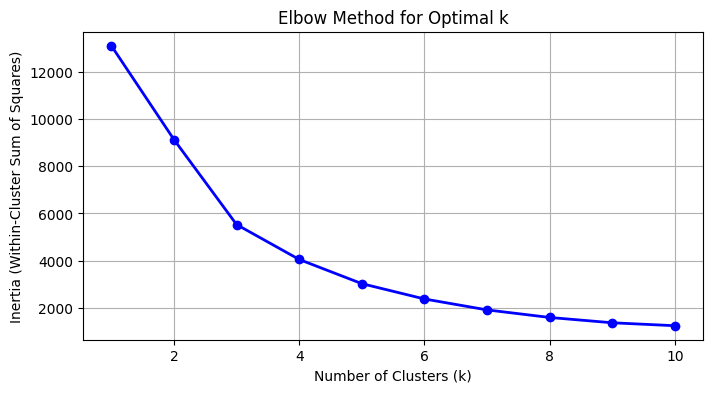

In [5]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Features for clustering
X = rfm_scaled[['Recency', 'Frequency', 'Monetary']]

# Range of k values
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bo-', linewidth=2)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


In [6]:
# Apply KMeans with chosen k
k = 4  # ← change this if your elbow suggested a better value
kmeans = KMeans(n_clusters=k, random_state=42)
rfm_scaled['Cluster'] = kmeans.fit_predict(rfm_scaled[['Recency', 'Frequency', 'Monetary']])

# Merge cluster labels back with original RFM data
rfm['Cluster'] = rfm_scaled['Cluster']

# Check mean RFM values by cluster
print(rfm.groupby('Cluster').mean(numeric_only=True).round(2))


c:\Users\Tanish\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


         CustomerID  Recency  Frequency   Monetary
Cluster                                           
0          15285.39    41.61       4.80    1478.52
1          15280.00     7.67      89.00  182181.98
2          15357.64   247.95       1.81     453.49
3          15139.50     9.18      40.67   18441.96


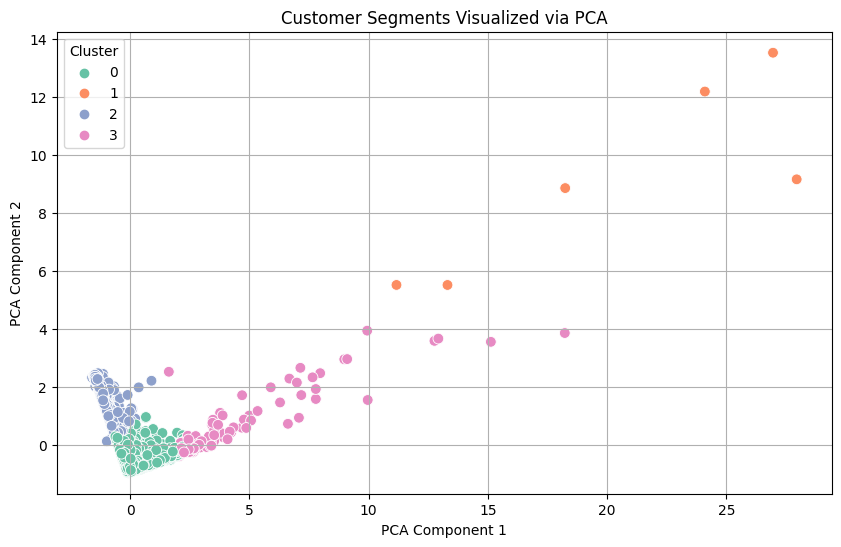

In [7]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_scaled[['Recency', 'Frequency', 'Monetary']])

# Create a new DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_components, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = rfm_scaled['Cluster']

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=60)
plt.title('Customer Segments Visualized via PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


In [9]:
import joblib

# Save scaler and kmeans model
joblib.dump(scaler, "scaler.pkl")
joblib.dump(kmeans, "kmeans_model.pkl")

print("✅ Models saved as 'scaler.pkl' and 'kmeans_model.pkl'")



✅ Models saved as 'scaler.pkl' and 'kmeans_model.pkl'
